# Regressor Model Training
### Load processed data, train models, and evaluate models

### Loading Data

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import re
import datetime
from tqdm import tqdm

ticker_symbol = "RTX"
merged_substituted_labeled_df = pd.read_pickle(f"../data/processed/{ticker_symbol}_merged_substituted_labeled_df.pkl")

In [2]:
# Only keep relevant data, so drop all the other features
relevant_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Next Adj Close', 'Volume', 'Negative Score', 'Neutral Score', 'Positive Score', 'Compound Score']
df = merged_substituted_labeled_df[relevant_columns]

In [4]:
# Feature data set
X = df.drop('Next Adj Close', axis=1)
X = np.array(X)

# Target data set
y = np.array(df['Next Adj Close'])

In [5]:
# We need to split the data into train and test sets, but you can't split time series data randomly due to look-ahead, so we will split first 75% and last 25%
split = int(0.75 * len(df))

X_train = X[0:split]
y_train = y[0:split]

X_test = X[split:]
y_test = y[split:]

In [6]:
# Data = {X_train:, y_train:, y_test:, X_test:}

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
def model_train_eval(model, data, parameters):    
    model_temp=GridSearchCV(model, parameters).fit(data["X_train"], data["y_train"])
    # model_temp=model.fit(data["X_train"], data["y_train"])
    y_pred=model_temp.predict(data["X_test"])
    mse=mean_squared_error(data["y_test"], y_pred)
    print("Mean Squared Error: ", mse)
    total=0
    for i, e in enumerate(y_pred):
        total+=abs((data["y_test"][i]-e)/data["y_test"][i])
    print(f"Mean Absolute Percentage Error: {total/len(y_pred)}")

In [7]:
from sklearn.linear_model import LinearRegression
data={"X_test":X_test, "X_train":X_train, "y_test":y_test, "y_train":y_train}
# The data here needs to be imported from the other data collection notebook
model_train_eval(LinearRegression(), data, {})

Mean Squared Error:  2.0561454913109167
Mean Absolute Percentage Error: 0.011470221851729464


In [9]:
from keras.models import Sequential
import keras_tuner
from keras.layers import LSTM, Dropout, Dense
hp=keras_tuner.HyperParameters()
model=Sequential()
model.add(LSTM(units=hp.Int("units", min_value=32, max_value=512, step=32),return_sequences=True, input_shape=(X_train.shape[1],1), activation=hp.Choice("activation", ["relu", "tanh"])))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', "mean_absolute_percentage_error"])

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=1000, batch_size=32)
print("Complete")
# y_pred=model.predict(X_test)

In [49]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

sc=MinMaxScaler(feature_range=(0,1))
sc.fit_transform(X)
booboo=model.predict(X_test)
yuh=mean_squared_error(data["y_test"], booboo)
print(yuh)
len(data["y_test"])
total=0
for i, e in enumerate(booboo):
    total+=abs((data["y_test"][i]-e)/data["y_test"][i])
print(f"MAPE: {total/len(booboo)}")

2/2 [==============================] - 5s 7ms/step
1997.9649516188028
MAPE: [0.13342288]


In [50]:
model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 5s 5s/step - loss: 1997.9651 - mean_squared_error: 1997.9651 - mean_absolute_error: 37.9537 - mean_absolute_percentage_error: 13.3423


[1997.965087890625, 1997.965087890625, 37.95368576049805, 13.342289924621582]

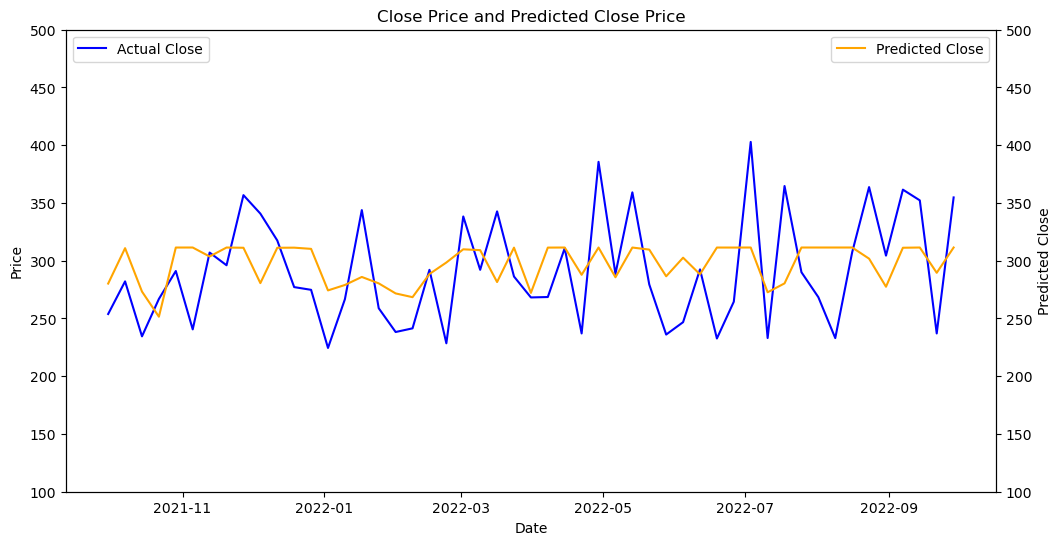

In [51]:
fig, ax1 = plt.subplots(figsize=(12, 6))
date_range = pd.date_range(start=df_merged['Date'].iloc[0], end=df_merged['Date'].iloc[-1], periods=len(y_pred))

# Stock data plot
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.plot(date_range, y_test, label='Actual Close', color='blue')
ax1.legend(loc='upper left')

# Predicted score plot
ax2 = ax1.twinx()
ax2.set_ylabel('Predicted Close')
ax2.plot(date_range, booboo, label='Predicted Close', color='orange')
ax2.legend(loc='upper right')

ax1.set_ylim(100, 500)
ax2.set_ylim(100, 500)

plt.title('Close Price and Predicted Close Price')

plt.show()